<a href="https://colab.research.google.com/github/kimdesok/DeepPATH/blob/master/Test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import tensorflow as tf
import sys
from sklearn import preprocessing
print(tf.__version__)

import random

!python --version

2.8.2
Python 3.7.13


In [2]:
!cp -r ./drive/MyDrive/datasets/TFRecord_Train ./TFRecord_Train

In [3]:
!cp -r ./drive/MyDrive/models/LUAD-Normal_model_finer_full_Adam_0.0001_80_0.7.h5 .

In [4]:
tf.keras.backend.clear_session()

#Set your parameters here

BATCH_SIZE = 300
BUFFER_SIZE = 2000
DROP_OUT = 0.7
REGULARIZER = 'l1'

SET_TYPE = 'small set' #full, ensemble, new, retrain

NO_EPOCHS = 200
PATIENCE = 15

LEARN_RATE = 0.01
LEARN_RATE1 = 0.0001

DECAY_RATE = 0.96
DECAY_STEPS = 10000

MODEL_NAME_FINAL = 'LUAD-Normal_model_full_Adam_0.01_80_0.7.h5'

MODEL_NAME_FINER = 'LUAD-Normal_model_finer_full_Adam_0.0001_80_0.7.h5'

AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [299, 299]

def decayed_learning_rate(step, initial_learning_rate=LEARN_RATE, decay_rate=DECAY_RATE, decay_steps=DECAY_STEPS):
    operand = step/float(decay_steps)
    return initial_learning_rate * decay_rate**(operand)

scale_layer = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1 / 127.5, offset=-1)

In [5]:
from functools import partial
import sys

def decode_image(image):
    
    image = tf.image.decode_jpeg(image,  channels=3)
    image = tf.cast(image, tf.float32)
    assert len(image.shape) == 3
    assert image.shape[2] == 3
    image = tf.reshape(image, [*IMAGE_SIZE, 3])    
    return image

"""
Dataset is loaded for the model to find features and patterns. 
The labels in the dataset provides the groundtruth information. 
"""
# To extract the image and the label data from each TFRecord
'''
The original TFRecord consists of the following data
          'image/height': tf.io.FixedLenFeature([], tf.int64),
          'image/width': tf.io.FixedLenFeature([], tf.int64),
          'image/colorspace': tf.io.FixedLenFeature([], tf.string),
          'image/channels': tf.io.FixedLenFeature([], tf.int64),
          'image/class/label': tf.io.FixedLenFeature([], tf.int64),
          'image/class/text': tf.io.VarLenFeature([], tf.string),
          'image/format': tf.io.FixedLenFeature([], tf.string),
          'image/filename': tf.io.VarLenFeature([], tf.string),
'''
def read_tfrecord(example, labeled=True):
  
    #To create a dictionary describing the features. 
    tfrecord_format = (
        {
              'image/encoded': tf.io.FixedLenFeature([], tf.string),
              'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        } 
        if labeled
        else {
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
        }
    )
    
    #Define a parser
    example = tf.io.parse_single_example(example, tfrecord_format)
    
    #Convert the data
    image = decode_image(example["image/encoded"])
    
    
    if labeled:
        label = tf.cast(example["image/class/label"], tf.int32) #No need to cast to tf.int32. why?
        return image, label
    return image

def load_dataset(filenames, labeled=True):
    
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    
    read_in_multi = partial(read_tfrecord, labeled=labeled)
    
    dataset = dataset.map(
        read_in_multi, num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset


#Get the dataset with JPEG images and labels together, shuffle, prefetch, and batch
def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE) # 64 is better for the unbalanced dataset
    return dataset

def plot_histogram(values):
    plt.figure(figsize=(16, 8))
    plt.rc('font', size=14) 
    plt.hist(values, bins=20)  # density=False would make counts
    plt.title("Model prediction distribution")
    plt.ylabel('Frequency')
    plt.xlabel('Prediction Values')

In [7]:
data_path ='./TFRecord_Train'
tfrecord_filenames = os.listdir(data_path)
test_data_filenames = [os.path.join(data_path, name) for name in tfrecord_filenames if 'test' in name]

# Shuffle the data filenames to remove the ordering

random.shuffle(test_data_filenames)

if(SET_TYPE == 'small set'):
    test_data_filenames = test_data_filenames[0:4]
    test_dataset = get_dataset(test_data_filenames)
    no_of_datafiles = int(len(test_data_filenames))

else:
    test_dataset = get_dataset(test_data_filenames)
    no_of_datafiles = int(len(test_data_filenames))
    
print('test_dataset is loaded with %d TFRecords.'%no_of_datafiles)
#print(type(test_dataset))

test_dataset is loaded with 4 TFRecords.


In [8]:
print('Loading the final model: %s'%MODEL_NAME_FINER)
model = tf.keras.models.load_model(MODEL_NAME_FINER)

initial_learning_rate = LEARN_RATE
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="binary_crossentropy",
    metrics=tf.keras.metrics.AUC(name="auc") #For the imbalanced data, AUC is the preferred metric.
)

Loading the final model: LUAD-Normal_model_finer_full_Adam_0.0001_80_0.7.h5


In [ ]:
#TFRecod files to image generator so it can be input to the predict()
local = True
def get_prediction(image_batch):
    
    print(type(image_batch))

    class_index = list()
    
    for x in image_batch:
        
        #rint('x shape:', np.array(x).shape)
        x = scale_layer(x)
        #x = tf.keras.preprocessing.image.img_to_array(x)
        x = tf.expand_dims(x, axis=0)
        #print('x shape:', np.array(x).shape)
        images = np.vstack([x])
        #print('images shape:', np.array(images).shape)
        
        value = model.predict(x)[0]
        #rint(value, end =' ')
        
        class_index.append(value)
        
    return class_index

if(local):
    test_dataset = load_dataset(test_data_filenames[0:10], labeled=False)
else:
    test_dataset = get_dataset(test_data_filenames[0:10])

#a MirroredStrategy object. This will handle distribution and provide a context manager 
# (MirroredStrategy.scope) to build your model inside.  
# https://www.tensorflow.org/tutorials/distribute/keras

strategy = tf.distribute.MirroredStrategy()
#print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

with strategy.scope():
    predict_list = get_prediction(test_dataset)
    print(len(predict_list))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
<class 'tensorflow.python.data.ops.dataset_ops.ParallelMapDataset'>


(898,)


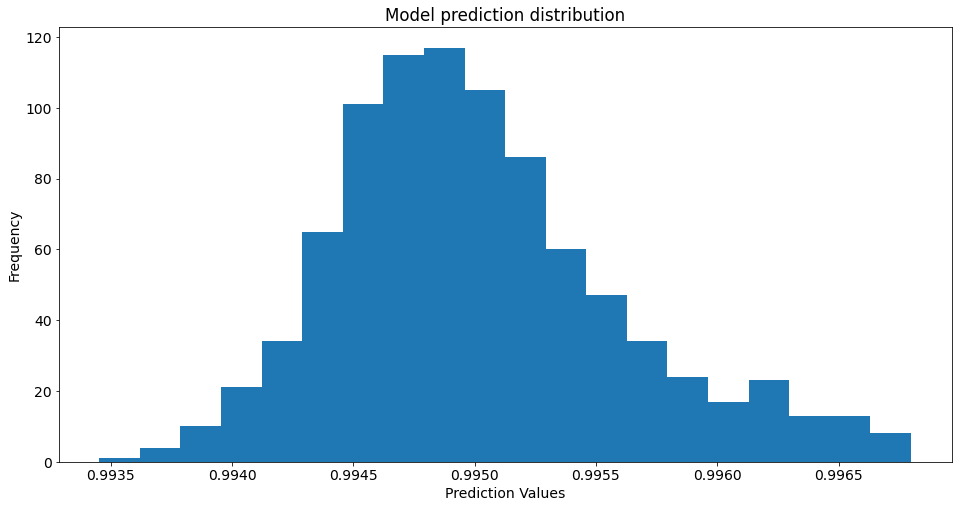

In [20]:
print(np.array(predict_list).flatten().shape)
plot_histogram(np.array(predict_list).flatten())

In [21]:
def get_label(label_batch):
   
    #print('Before inverse transform, Normal ', list(label_batch).count(0), ' Tumor ',  list(label_batch).count(1))
    #To print out the label of the image
    le = preprocessing.LabelEncoder()
    le.fit(['Tumor','Normal'])
    
    nums = label_batch #.numpy()
    print(nums)
    
    labels = list(le.inverse_transform(nums))
     
    #print('After inverse transform, Normal ', list(labels).count('Normal'), ' Tumor ',  list(labels).count('Tumor'))
    
    return labels

def plot_histogram(values):
    plt.figure(figsize=(16, 8))
    plt.rc('font', size=14) 
    plt.hist(values, bins=20)  # density=False would make counts
    plt.title("Model prediction distribution")
    plt.ylabel('Frequency')
    plt.xlabel('Prediction Values')
    
def get_accuracy(test_array, predict_array, threshold=0.5):
    #print(type(test_labels))
    #print(type(predict_values))
    predicted = []
    true_positive, true_negative = 0,0
    false_positive, false_negative = 0,0
    for idx in range(len(test_array)):
        y = test_array[idx]
        if(predict_array[idx] > threshold) :
            predicted.append('Tumor')
            if(y == 'Tumor'):
                true_positive += 1               
            else:
                false_negative += 1
        else:
            predicted.append('Non Tumor')
            if(y == 'Normal'): 
                true_negative += 1
            else:
                false_positive += 1
                
        #print(predict_array[idx], test_array[idx], end=' ')
        #break
    accuracy = (true_positive + true_negative) / float(true_positive + true_negative  + false_negative + false_positive + 0.0000001)
    sensitivity = true_positive / float(true_positive + false_negative + 0.0000001)
    specificity = true_negative / float(true_negative + false_positive + 0.0000001)
    precision = true_positive / float(true_positive + false_positive + 0.0000001)
    recall = true_positive / float(true_positive + false_negative + 0.0000001)
    f1_score = 2.0*precision*recall / (precision + recall + 0.0000001)
    print('%0.3f %0.3f %0.3f %0.3f %0.3f %0.3f' \
          %(accuracy, specificity,sensitivity, precision,recall,f1_score))
    return predicted

def show_batch_predictions(image_batch, predicted):
    plt.figure(figsize=(20, 120))
    no_images = len(image_batch)
    col = 4
    row = int(no_images/col) + 1
    for n in range(no_images):
        ax = plt.subplot(row, col, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        img_array = tf.expand_dims(image_batch[n], axis=0)
        plt.title(str(model.predict(img_array)[0]) + ' ' + str(predicted[n]))
        plt.axis("off")
    
    plt.show()
    plt.pause(0.1)